In [3]:
import tensorflow
import numpy as np
import pandas as pd
import os
import tensorflow.keras as keras
zip_file=keras.utils.get_file(
    fname="gamma_angle_position_5deg_xy.h5",
    origin="https://zenodo.org/record/846388/files/gamma_angle_position_5deg_xy.h5?download=1",
    extract=True

)
dirnam=os.path.join(os.path.dirname(zip_file), "gamma_angle_position_5deg_xy.h5")
import h5py
#data imported

In [4]:
#Input Genration Algorithm-Particle Position Finder
def max_loc(layer):
    layer_flat_2D=layer.reshape(layer.shape[0],layer.shape[1]*layer.shape[2])
    maxx = np.argmax(layer_flat_2D,axis=1)%layer.shape[2]
    maxy = np.argmax(layer_flat_2D,axis=1)//layer.shape[2]
    max = np.stack([maxx,maxy],axis=1)
    return max
    #maxes = Layer_1_data_preprocessed.take(max)

In [5]:
#Input Extraction
def extract_message(layers):
    max_coor = max_loc(layers)
    print(max_coor.shape)
    e_message = np.zeros((1,3,3))
    message = np.empty((500000,3,3))
    print(max_coor[0,0])
    for index in range(max_coor.shape[0]):
        if(max_coor[index,0] > 1 and max_coor[index,1] > 1 and  max_coor[index,0] < layers.shape[2]-1 and max_coor[index,1] < layers.shape[1]-1):
            test = np.array(layers[index,max_coor[index,1]-1:max_coor[index,1]+2,max_coor[index,0]-1:max_coor[index,0]+2])
        else:
            test = e_message
        if index == 12 : 
            print(test)
        message[index] =  test
    return message
#first gnn model input extraction

In [6]:
#Data Generation
layer_0_data = (np.array(h5py.File(zip_file)["layer_0"][:]))
layer_1_data = (np.array(h5py.File(zip_file)["layer_1"][:]))
layer_2_data = (np.array(h5py.File(zip_file)["layer_2"][:]))
energy=(np.array(h5py.File(zip_file)["energy"]))
order = np.arange(0, energy.shape[0])
np.random.shuffle(order)
energy=energy.reshape(energy.shape[0])
energy_s = energy[order]
layer_0_data_s = layer_0_data[order] 
layer_1_data_s = layer_1_data[order] 
layer_2_data_s = layer_2_data[order] 


nottobe_merged = max_loc(layer_1_data_s) == max_loc(layer_1_data)

print(layer_0_data.shape)

nrm_e=np.max(energy)


#data classes imported

(500000, 3, 96)


In [8]:
#The Gaussian Noise
rng = np.random.default_rng()
noise_l0 = rng.normal(0,167,layer_0_data.shape[0]*layer_0_data.shape[1]*layer_0_data.shape[2])
noise_l0 = noise_l0.reshape(layer_0_data.shape[0],layer_0_data.shape[1],layer_0_data.shape[2])
mask = np.zeros([layer_0_data.shape[1],layer_0_data.shape[2]])
layer_0_data= layer_0_data# + noise_l0
nrm_l0=np.max(layer_0_data)
layer_0_data[layer_0_data<0] = 0



noise_l1 = rng.normal(0,167,layer_1_data.shape[0]*layer_1_data.shape[1]*layer_1_data.shape[2])
noise_l1 = noise_l1.reshape(layer_1_data.shape[0],layer_1_data.shape[1],layer_1_data.shape[2])
mask = np.zeros([layer_1_data.shape[1],layer_1_data.shape[2]])
layer_1_data = layer_1_data#+ noise_l1
nrm_l1=np.max(layer_1_data)
layer_1_data[layer_1_data<0] = 0

noise_l2 = rng.normal(0,167,layer_2_data.shape[0]*layer_2_data.shape[1]*layer_2_data.shape[2])
noise_l2 = noise_l2.reshape(layer_2_data.shape[0],layer_2_data.shape[1],layer_2_data.shape[2])
mask = np.zeros([layer_2_data.shape[1],layer_2_data.shape[2]])
layer_2_data = layer_2_data# + noise_l2
nrm_l2=np.max(layer_2_data)
layer_2_data[layer_2_data<0] = 0

Layer_0_data_preprocessed=(layer_0_data)/nrm_l0
Layer_1_data_preprocessed=(layer_1_data)/nrm_l1
Layer_2_data_preprocessed=(layer_2_data)/nrm_l2
energy = energy / nrm_e
#data, noise and preprocessing 

In [9]:
messages_l1_gnn = extract_message(Layer_1_data_preprocessed)
messages_l2_gnn = extract_message(Layer_2_data_preprocessed)
#First GNN Inputs

(500000, 2)
6
[[0.00760367 0.02254065 0.01318654]
 [0.02211892 0.77083919 0.07237   ]
 [0.01185242 0.0664807  0.02532525]]
(500000, 2)
3
[[1.44615634e-04 2.96960331e-04 1.61899489e-03]
 [0.00000000e+00 1.80149791e-03 1.30472245e-03]
 [3.95087883e-04 7.78432114e-05 1.67594708e-04]]


In [10]:
#Data Preprocessing and Exclusion of Some Data
def empty2D(par):
    empty1=par==np.zeros((3,3))
    empty1=np.logical_and.reduce(empty1, axis = 2)
    empty1=np.array(np.where(empty1==True))
    empty1=empty1[0]
    empty1=set(empty1)
    return empty1
def intersect2L(layer1,layer2):
    intersect=layer1.union(layer2)
    return intersect
emp1=empty2D(messages_l1_gnn)
emp2=empty2D(messages_l2_gnn)
excluded_data1=intersect2L(emp1,emp2)
excluded_data1=np.array([list(excluded_data1)])
excluded_data1.shape
included_data1=[]
for index in range(messages_l1_gnn.shape[0]):
    if ((index in excluded_data1)==False):
        included_data1.append(index)

In [11]:
#Final Inputs
inp1_gnnbaseline=np.copy(Layer_0_data_preprocessed)[included_data1]
messages_l1_gnn1=np.copy(messages_l1_gnn)[included_data1]
messages_l2_gnn1=np.copy(messages_l2_gnn)[included_data1]
inp1_gnnbaseline.shape

(386685, 3, 96)

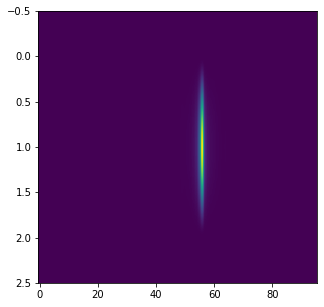

In [19]:
#Model Checking
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(inp1_gnnbaseline[5],aspect="auto")

In [114]:
#Layer Check Algorithm Substitutes
def check_layer_0(ind):
    fig, ax=plt.subplots(1,3)
    ax[0].imshow(layer_0_data_st[ind], aspect="auto")
    ax[1].imshow(particle0_1[ind])
    print(max_loc(layer_0_data_st)[ind,1])
    ax[2].imshow(particle0_2[ind])
    print(particle0_1[ind], particle0_2[ind])
    print(max_loc(layer_0_data_st)[ind])
    print(max_loc(layer_clone_0_1)[ind])
def check_layer_2(ind):
    fig, ax=plt.subplots(1,3)
    ax[0].imshow(layer_2_data_st[ind], aspect="auto")
    ax[1].imshow(particle2_1[ind])
    print(max_loc(layer_2_data_st)[ind,1])
    ax[2].imshow(particle2_2[ind])
    print(particle2_1[ind], particle2_2[ind])
    print(max_loc(layer_2_data_st)[ind])
    print(max_loc(layer_clone_2_1)[ind])
def check_layer_1(int):
    fig, ax=plt.subplots(1,4)
    ax[0].imshow(particle1_1[int])
    ax[1].imshow(layer_1_data_st[int])
    ax[2].imshow(particle1_2[int])
    ax[3].imshow(layer_clone_1_1[int])
    print(max_loc(layer_1_data_st)[int])
    print(max_loc(layer_clone_1_1)[int])
    print(particle1_1[int])
    print(particle1_2[int])

In [244]:
#DNN and CNN Input Generation
layer1_flat_2D=np.reshape(Layer_1_data_preprocessed,[500000,144])
maxx = np.argmax(layer1_flat_2D,axis=1)//12
maxy = np.argmax(layer1_flat_2D,axis=1)%12
max = np.stack([maxy,maxx],axis=1)
maxes = Layer_1_data_preprocessed.take(max)
print(maxx[0])
print(maxy[0])
print(Layer_1_data_preprocessed[0][5][6])
print(maxes.shape)
print(maxes[0])

5
6
0.7210057179529423
(500000, 2)
[0.         0.00139134]


In [54]:
#DNN Input Preprocessing-1
flatten_layer_0=Layer_0_data_preprocessed.reshape(500000,3*96)
flatten_layer_1=Layer_1_data_preprocessed.reshape(500000,12*12)
flatten_layer_2=Layer_2_data_preprocessed.reshape(500000,6*12)
#from random import randint

In [12]:
#Test-Train Split
from sklearn.model_selection import train_test_split
#layer_0_train, layer_0_test, energy_train, energy_test,  layer_1_train,layer_1_test, layer_2_train, layer_2_test= train_test_split(flatten_layer_0,  energy, flatten_layer_1, flatten_layer_2,  test_size=0.4, random_state=42)
#layer_0_train_2D, layer_0_test_2D, energy_train, energy_test,layer_1_train2d,layer_1_test2d,layer_2_train2d,layer_2_test2d=train_test_split(Layer_0_data_preprocessed,  energy, Layer_1_data_preprocessed, Layer_2_data_preprocessed,test_size=0.4, random_state=42)
energy_gnn_train,energy_gnn_test,layer0gnn_train,layer0_gnn_test, messages_l1_gnn_train, messages_l1_gnn_test, messages_l2_gnn_train, messages_l2_gnn_test= train_test_split(energy[included_data1],inp1_gnnbaseline, messages_l1_gnn1, messages_l2_gnn1 ,test_size=0.4, random_state=42)

In [56]:
#DNN Input Preprocessing-2
lc1_test=np.array([np.concatenate((layer_0_test, layer_1_test, layer_2_test),axis=1)  ])
lc1_train=np.array([np.concatenate((layer_0_train, layer_1_train, layer_2_train),axis=1)  ])
lc1_train=lc1_train.reshape(lc1_train.shape[1],lc1_train.shape[2])
lc1_test=lc1_test.reshape(lc1_test.shape[1],lc1_test.shape[2])

In [57]:
print(lc1_test.shape) 
print(energy_test.shape)
print(lc1_train.shape)
print(energy_train.shape) 

(200000, 504)
(200000,)
(300000, 504)
(300000,)


In [13]:
#Model Run Settings
def run_experiment(model, x_train, y_train):
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.003),
        loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")#,
        #metrics=tf.keras.metrics.BinaryAccuracy(),
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, restore_best_weights=True
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=200,
        batch_size=1024,
        validation_split=0.2,
        callbacks=[early_stopping],
    )

    return history

In [14]:
#DNN
import keras.layers as layers
import tensorflow as tf
hidden_units = [1024, 512,64]
def dnn(hidden_units, num_classes, dropout_rate):
    inputs = layers.Input(shape=(144+(96*3)+72,), name="input_features")
    x = inputs
    for units in hidden_units:        
        x  = layers.Dense(units, activation=tf.nn.relu)(x)
        x  = layers.Dropout(rate=dropout_rate)(x)
    logits = layers.Dense(num_classes, name="output")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="dnn")
baseline_model = dnn(hidden_units, 1, 0)
baseline_model.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 504)]            0         
                                                                 
 dense (Dense)               (None, 1024)              517120    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0       

In [21]:
#CNN
def cnn(hidden_units, num_classes, dropout_rate):
    inputs0 = layers.Input(shape=(3,96,1,), name="input_features_l0")
    inputs1 = layers.Input(shape=(12,12,1,), name="input_features_l1")
    inputs2 = layers.Input(shape=(12,6,1,), name="input_features_l2")
    cnn0 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs0)
    cnn0 = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn0)
    #cnn0 = layers.Conv2D(128, 5, activation='relu', padding='same')(cnn0)
    cnn0 = layers.Flatten()(cnn0)
    inputs0_flat = layers.Flatten()(inputs0)
    cnn0Comb = layers.Concatenate()([cnn0,inputs0_flat])
    cnn1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs1)
    cnn1 = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn1)
    #cnn1 = layers.Conv2D(128, 5, activation='relu', padding='same')(cnn1)
    cnn1 = layers.Flatten()(cnn1)
    inputs1_flat = layers.Flatten()(inputs1)
    cnn1Comb = layers.Concatenate()([cnn1,inputs1_flat])
    cnn2 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs2)
    cnn2 = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn2)  
    #cnn2 = layers.Conv2D(128, 5, activation='relu', padding='same')(cnn2)      
    cnn2 = layers.Flatten()(cnn2)
    inputs2_flat = layers.Flatten()(inputs2)
    cnn2Comb = layers.Concatenate()([cnn2,inputs2_flat])
    x =  layers.Concatenate()([cnn0Comb,cnn1Comb,cnn2Comb])
    for units in hidden_units:        
        x  = layers.Dense(units, activation=tf.nn.relu)(x)
        x  = layers.Dropout(rate=dropout_rate)(x)
    logits = layers.Dense(num_classes, name="output")(x)
    return keras.Model(inputs=(inputs0,inputs1,inputs2), outputs=logits, name="cnn")

In [15]:
#GNN
def gnn(hidden_units, num_classes, dropout_rate):
    inputs0 = layers.Input(shape=(3,96,1,), name="input_features_l0")
    inputs1 = layers.Input(shape=(3,3,1,), name="input_features_l1")
    inputs2 = layers.Input(shape=(3,3,1,), name="input_features_l2")
    cnn0 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs0)
    cnn0 = layers.Conv2D(64, 3, activation='relu', padding='same')(cnn0)
    #cnn0 = layers.Conv2D(128, 5, activation='relu', padding='same')(cnn0)
    cnn0 = layers.Flatten()(cnn0)
    inputs0_flat = layers.Flatten()(inputs0)
    cnn0Comb = layers.Concatenate()([cnn0,inputs0_flat])
    cnn1 = layers.Conv2D(32, 2, activation='relu', padding='same')(inputs1)
    #cnn1 = layers.Conv2D(64, 2, activation='relu', padding='same')(cnn1)
    #cnn1 = layers.Conv2D(128, 5, activation='relu', padding='same')(cnn1)
    cnn1 = layers.Flatten()(cnn1)
    inputs1_flat = layers.Flatten()(inputs1)
    cnn1Comb = layers.Concatenate()([cnn1,inputs1_flat])
    cnn2 = layers.Conv2D(32, 2, activation='relu', padding='same')(inputs2)
    #cnn2 = layers.Conv2D(64, 2, activation='relu', padding='same')(cnn2)  
    #cnn2 = layers.Conv2D(128, 5, activation='relu', padding='same')(cnn2)      
    cnn2 = layers.Flatten()(cnn2)
    inputs2_flat = layers.Flatten()(inputs2)
    cnn2Comb = layers.Concatenate()([cnn2,inputs2_flat])
    x =  layers.Concatenate()([cnn0Comb,cnn1Comb,cnn2Comb])
    for units in hidden_units:        
        x  = layers.Dense(units, activation=tf.nn.relu)(x)
        x  = layers.Dropout(rate=dropout_rate)(x)
    logits = layers.Dense(num_classes, name="output")(x)
    return keras.Model(inputs=(inputs0,inputs1,inputs2), outputs=logits, name="gnn")

In [16]:
gnn_model = gnn(hidden_units, 1, 0.1)
gnn_model.summary()

Model: "gnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features_l0 (InputLayer)  [(None, 3, 96, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 3, 96, 32)    320         ['input_features_l0[0][0]']      
                                                                                                  
 input_features_l1 (InputLayer)  [(None, 3, 3, 1)]   0           []                               
                                                                                                  
 input_features_l2 (InputLayer)  [(None, 3, 3, 1)]   0           []                               
                                                                                                

In [26]:
#GNN Training
history_gnn=run_experiment(gnn_model,[layer0gnn_train,messages_l1_gnn_train,messages_l2_gnn_train],energy_gnn_train)

Epoch 1/50
182/182 [==============================] - 26s 136ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 2/50
182/182 [==============================] - 24s 135ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/50
182/182 [==============================] - 25s 138ms/step - loss: 0.0016 - val_loss: 9.2584e-04
Epoch 4/50
182/182 [==============================] - 25s 135ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/50
182/182 [==============================] - 25s 135ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/50
182/182 [==============================] - 24s 135ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/50
182/182 [==============================] - 25s 135ms/step - loss: 0.0010 - val_loss: 6.8330e-04
Epoch 8/50
182/182 [==============================] - 24s 134ms/step - loss: 9.5990e-04 - val_loss: 0.0011
Epoch 9/50
182/182 [==============================] - 24s 134ms/step - loss: 9.2027e-04 - val_loss: 6.9366e-04
Epoch 10/50
182/182 [==============================] 

In [18]:
#GNN Prediction
gnn_predict=gnn_model.predict(x=[layer0_gnn_test,messages_l1_gnn_test,messages_l2_gnn_test], verbose=1)

4834/4834 [==============================] - 17s 3ms/step


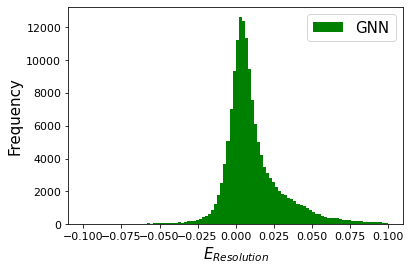

In [25]:
np.array(gnn_predict)
import matplotlib.pyplot as plt
fig, ax =plt.subplots(1,1)
par_diff=(np.array(gnn_predict)[:,0]-np.array(energy_gnn_test)[:])/np.array(energy_gnn_test)[:]
plt.hist(par_diff,range=[-0.1,0.1],bins=100, color="g", label="GNN")
ax.set_ylabel("Frequency", fontsize=15)
ax.tick_params(labelsize=11)
ax.set_xlabel("$E_{\t{Resolution}}$", fontsize=15)
ax.legend(fontsize=15)

(array([9.74039584e-03, 2.92211766e-02, 5.77930370e-02, 1.09092352e-01,
        1.74028406e-01, 1.81171363e-01, 2.40263097e-01, 2.91562516e-01,
        3.36368085e-01, 4.59097324e-01, 5.59098721e-01, 6.92217465e-01,
        6.01307103e-01, 6.88970666e-01, 7.98712459e-01, 7.62348315e-01,
        7.22088012e-01, 7.15594415e-01, 7.27281801e-01, 8.43518280e-01,
        9.85078700e-01, 9.64299189e-01, 9.96768667e-01, 1.02793490e+00,
        1.01430141e+00, 9.92220172e-01, 1.04222080e+00, 1.05521113e+00,
        1.10520859e+00, 1.13053697e+00, 1.10066308e+00, 1.12469272e+00,
        1.10975411e+00, 1.03832775e+00, 9.72090050e-01, 9.06507530e-01,
        1.33832839e+00, 1.30066558e+00, 1.17664158e+00, 1.05975348e+00,
        9.61053828e-01, 1.06429899e+00, 1.12274464e+00, 1.10975411e+00,
        9.93521863e-01, 1.11235154e+00, 1.25521422e+00, 1.17533934e+00,
        1.09027334e+00, 9.77284920e-01, 8.80535738e-01, 1.48313539e+00,
        1.21040471e+00, 8.76634314e-01, 1.33833640e+00, 1.458459

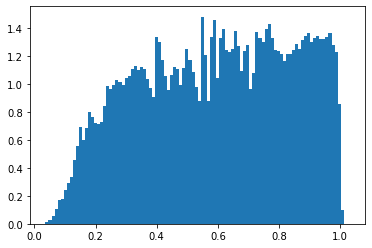

In [69]:
#Plotting Predictions
plt.hist(gnn_predict,bins= 100, density = True, label="GNN predict")

In [ ]:
#Comparitive Plotting of All Models
energy = np.array(energy)
dnn_predict = np.array(dnn_predict)
cnn_predict = np.array(cnn_predict)
fig, ax = plt.subplots(1,2,figsize=[10,5])

ax[0].hist(energy[:,0],bins= 100, density= True, label="Sum energy") 
ax[0].hist(dnn_predict[:,0],bins= 100, density = True , alpha = 0.4,  label="DNN predict")
#ax[0].hist(cnn_predict[:,0],bins= 100, density = True, alpha = 0.4, label="CNN predict")
ax[0].hist(gnn_predict[:,0],bins= 100, density = True, alpha = 0.4, label="GNN predict")

ax[0].legend()

ax[1].hist(energy[:,1],bins= 100, density= True, label="Sum energy") 
#ax[1].hist(dnn_predict[:,1],bins= 100, density = True , alpha = 0.4,  label="DNN predict")
ax[1].hist(cnn_predict[:,1],bins= 100, density = True, alpha = 0.4, label="CNN predict")

plt.legend()


Text(0.5, 1.0, 'GNN Energy Reconstruction Training without Noise')

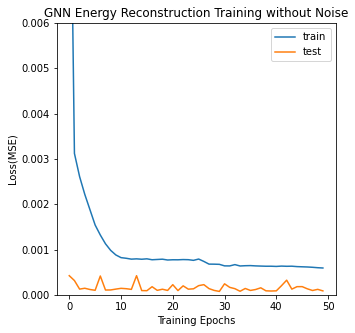

In [75]:
#GNN Training in the Absence of Gaussian Noise
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(history_gnn.history["loss"])
ax1.plot(history_gnn.history["val_loss"])
ax1.set_ylim(top  = 0.006, bottom = 0.0)
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Training Epochs")
ax1.set_ylabel("Loss(MSE)")
ax1.set_title("GNN Energy Reconstruction Training without Noise")

In [ ]:
plt.plot(history_gnn.history["loss"])
plt.plot(history_gnn.history["val_loss"])
plt.ylim(top  = 0.01, bottom = 0.0)
plt.legend(["train", "test"], loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("loss")

In [ ]:
#dnn_predict = dnn_predict.reshape(dnn_predict.shape[0])
energy_cut  = 0 / (nrm_e * 1000)
dnn_diff_pred = (dnn_predict - energy_test)/ energy_test
diff_sum = (np.sum(layer_0_test,axis=1)/2*nrm_l0+np.sum(layer_1_test,axis=1)/2*nrm_l1+np.sum(layer_2_test,axis=1)/2*nrm_l2 - energy_test[:,0]*nrm_e*1000 + 0.0068*energy_test[:,0]*nrm_e*1000)/(energy_test[:,0]*nrm_e*1000)
print(np.argmin(diff_sum))
print(np.sum(diff_sum>0))

print(np.std(dnn_diff_pred))
print(np.std(diff_sum))
print(np.mean(dnn_diff_pred))
print(np.mean(diff_sum))

In [ ]:

def check_predict(n):
    print(cnn_predict[n], energy_test[n], (diff_sum[n]*energy_test[n]*nrm_e+energy_test[n]*nrm_e)/100)
check_predict(100)

In [ ]:
#Cnn_nparr=cnn_predict[:,0]
gnn_nparr=gnn_predict[:,0]


In [ ]:
#cnn_diff_predict=(Cnn_nparr-energy_test[:,0])/energy_test[:,0]
gnn_diff_predict=(gnn_nparr-energy_test)/energy_test
plt.hist(gnn_predict, bins=20)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=[5,5])
ax.hist(dnn_diff_pred, bins = 100, range=[-0.1,0.1], label = "dnn pred") 
#ax.hist(diff_sum, alpha = 0.6, bins = 100, range=[-0.1,0.1], label = "sum algo", color="r")
ax.hist(gnn_diff_predict,  bins = 100, range=[-0.1,0.1],color="g", label = "cnn pred") 
ax.legend()

In [10]:
inp1_gnnbaseline=np.copy(Layer_0_data_preprocessed)[included_data1]
messages_l1_gnn1=np.copy(messages_l1_gnn)[included_data1]
messages_l2_gnn1=np.copy(messages_l2_gnn)[included_data1]
inp1_gnnbaseline.shape

(386685, 3, 96)